In [192]:
import numpy as np
import pandas as pd
from keras.layers import Input, Conv1D, AveragePooling1D, MaxPooling1D, Dropout, Embedding, LSTM, Dense, Bidirectional, TimeDistributed, concatenate, Flatten, BatchNormalization
from keras.layers import Embedding
from keras.models import Model
from keras.preprocessing.text import Tokenizer

import tensorflow as tf
from keras import backend as K
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.layers import add
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from matplotlib import pyplot as plt

In [189]:
df = pd.read_csv("../real_train.csv")

In [ ]:
Tokenizer()

In [191]:
df.Peptide

0        DSMQYTYKIV
1         SLLKYFFVL
2        ILYVPMSLSM
3         NQLLARPFL
4         AEMEKEGKI
5         IYFEKNKTL
6          VNFVCQRV
7         CPILSTINI
8         VCYYLLMHL
9          SIIRFEKL
10       CSNIQYGYKI
11      ISQILSKTIAL
12        NNLVKWPLL
13       DFFPDLNALV
14        LPSLPIFDI
15       KFPTNTLTSI
16       DVVCNAAMLI
17        MSVLNDQYA
18         QQWNFAGI
19        VNNTATLLM
20        ASKQNLDSI
21       QAYYWLLTAL
22       AQREIFSAWI
23        QLSPYPFDL
24         INYLVPFL
25        IGLCKTLGS
26        RYHVVLTMA
27       SAFIVYYYHI
28        KQTCNSSAV
29       NSSILFPDDV
           ...     
5854      LIIVQIILL
5855       QTFRFMHL
5856       FPPNYKLL
5857      VILALYSAM
5858     SGVNMFRNHL
5859       SPGQLIQR
5860     IRLINDSTDV
5861     YAIAMLPVFL
5862       SVIFLAIL
5863      IPLTNITYW
5864       EEGEGRVI
5865      GYIREALVI
5866       AIKPYNPL
5867      KNIQSLRRL
5868       LAILYILL
5869       LLFNFLSL
5870      TYWCYITEL
5871      STPAHHHSL
5872    PVFFYYILGLM


In [ ]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rtrain-AUC: %s - val-AUC: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return


In [3]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [160]:
peptides = np.load('peptides.npy')
mhc = np.load('mhc.npy')
affinity = np.log(1+np.load('affinity.npy'))/10
labels = np.load('immu.npy')

(array([147., 360., 479., 608., 690., 767., 853., 789., 652., 539.]),
 array([0.09633163, 0.19333493, 0.29033823, 0.38734153, 0.48434483,
        0.58134813, 0.67835143, 0.77535473, 0.87235803, 0.96936133,
        1.06636462]),
 <a list of 10 Patch objects>)

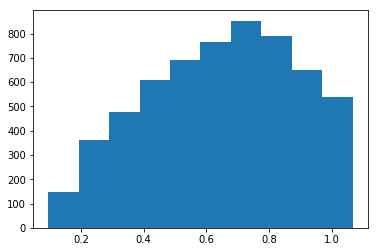

In [161]:
plt.hist(affinity)

In [67]:
peptides_A = peptides[:, :, :20]
peptides_B = peptides[:, :, 20:]
peptides_A.shape, peptides_B.shape

((5884, 11, 20), (5884, 11, 11))

In [166]:
input_1_A.shape

NameError: name 'input_1_A' is not defined

In [171]:
input_1 = Input(shape=(11, 20,), name = 'input_1')
x1 = Embedding(input_dim = 20, output_dim=12)(input_1)

input_2 = Input(shape=(11, 11,), name = 'input_2')

x2 = concatenate([x1, input_2], axis=-1)

x2 = Conv1D(16, 3, padding='same', activation = 'elu')(x2)
x2 = BatchNormalization()(x2)
x2 = AveragePooling(3)(x2)

x2_a = Conv1D(16, 3, padding='same', activation = 'elu')(x2)
x2_a = BatchNormalization()(x2_a)
x3 = add([x2, x2_a])
x3 = Conv1D(32, 3, padding='same', activation = 'elu')(x3)
x3 = MaxPooling1D(x3)                 
x3 = BatchNormalization()(x3)
x3 = Flatten()(x3)

merged = concatenate([x3, input_3], axis=-1)
x4 = Dense(32, activation = 'relu')(merged)
x4 = Dropout(0.3)(x4)
x4 = Dense(32, activation = 'relu')(x4)
x4 = Dropout(0.3)(x4)
predictions = Dense(2, activation='softmax')(x4)

model = Model(inputs=[input_1, input_2, input_3], outputs=predictions)

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 11, 20, 12), (None, 11, 11)]

In [118]:
model.compile(optimizer=Adam(lr=0.0012), loss='categorical_crossentropy', metrics=['accuracy', auc])

In [119]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 11, 31)       0                                            
__________________________________________________________________________________________________
batch_normalization_112 (BatchN (None, 11, 31)       124         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_71 (Conv1D)              (None, 11, 16)       1504        batch_normalization_112[0][0]    
__________________________________________________________________________________________________
batch_normalization_113 (BatchN (None, 11, 16)       64          conv1d_71[0][0]                  
__________________________________________________________________________________________________
conv1d_72 

In [120]:
model.fit([peptides, affinity], to_categorical(labels), batch_size=32, validation_split=0.1, epochs=30)

Train on 5295 samples, validate on 589 samples
Epoch 1/30
5295/5295 [==============================] - 13s 3ms/step - loss: 0.4482 - acc: 0.8100 - auc: 0.8701 - val_loss: 0.4874 - val_acc: 0.7827 - val_auc: 0.8704
Epoch 2/30
5295/5295 [==============================] - 4s 728us/step - loss: 0.4377 - acc: 0.8093 - auc: 0.8726 - val_loss: 0.4890 - val_acc: 0.7929 - val_auc: 0.8734
Epoch 3/30
5295/5295 [==============================] - 4s 719us/step - loss: 0.4461 - acc: 0.8091 - auc: 0.8740 - val_loss: 0.4890 - val_acc: 0.7776 - val_auc: 0.8732
Epoch 4/30
5295/5295 [==============================] - 4s 720us/step - loss: 0.4200 - acc: 0.8204 - auc: 0.8751 - val_loss: 0.4984 - val_acc: 0.7844 - val_auc: 0.8763
Epoch 5/30
5295/5295 [==============================] - 4s 753us/step - loss: 0.4226 - acc: 0.8225 - auc: 0.8776 - val_loss: 0.4943 - val_acc: 0.7657 - val_auc: 0.8779
Epoch 6/30
5295/5295 [==============================] - 4s 740us/step - loss: 0.4177 - acc: 0.8236 - auc: 0.8796 -

In [176]:
input_1 = Input(shape=(11, 31,), name = 'input_1')
#input_2 = Input(shape=(6,), name = 'input_2')
input_3 = Input(shape=(1,), name = 'input_3')

x1 = Conv1D(16, 3, padding='same', activation = 'elu')(input_1)
x1 = BatchNormalization()(x1)

x1_a = Conv1D(16, 3, padding='same', activation = 'elu')(x1)
x1_a = BatchNormalization()(x1_a)

x2 = add([x1, x1_a])
x2 = Conv1D(32, 3, padding='same', activation = 'elu')(x1)
x2 = BatchNormalization()(x2)
#x2 = MaxPooling1D()(x2)
x2 = Flatten()(x2)

merged = concatenate([x2, input_3], axis=-1)
x4 = Dense(32, activation = 'relu')(merged)
x4 = Dropout(0.3)(x4)
x4 = Dense(32, activation = 'relu')(x4)
x4 = Dropout(0.3)(x4)
predictions = Dense(2, activation='softmax')(x4)

model_2 = Model(inputs=[input_1, input_3], outputs=predictions)

In [177]:
model_2.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy', auc])

In [178]:
model_2.fit([peptides, affinity], to_categorical(labels), batch_size=64, validation_split=0.1, epochs=10)

Train on 5295 samples, validate on 589 samples
Epoch 1/10
5295/5295 [==============================] - 27s 5ms/step - loss: 0.6065 - acc: 0.7330 - auc: 0.7249 - val_loss: 0.5103 - val_acc: 0.7861 - val_auc: 0.7764
Epoch 2/10
5295/5295 [==============================] - 2s 347us/step - loss: 0.5344 - acc: 0.7815 - auc: 0.7865 - val_loss: 0.5017 - val_acc: 0.7861 - val_auc: 0.7954
Epoch 3/10
5295/5295 [==============================] - 2s 357us/step - loss: 0.5229 - acc: 0.7862 - auc: 0.8000 - val_loss: 0.5133 - val_acc: 0.7861 - val_auc: 0.8034
Epoch 4/10
5295/5295 [==============================] - 2s 361us/step - loss: 0.5088 - acc: 0.7881 - auc: 0.8068 - val_loss: 0.5021 - val_acc: 0.7861 - val_auc: 0.8094
Epoch 5/10
5295/5295 [==============================] - 2s 392us/step - loss: 0.5087 - acc: 0.7883 - auc: 0.8115 - val_loss: 0.5030 - val_acc: 0.7861 - val_auc: 0.8132
Epoch 6/10
5295/5295 [==============================] - 2s 347us/step - loss: 0.5015 - acc: 0.7890 - auc: 0.8147 -

In [186]:
def get_model():
    input_1 = Input(shape=(11, 31,), name = 'input_1')
    input_3 = Input(shape=(1,), name = 'input_3')

    x1 = Conv1D(16, 3, padding='same', activation = 'elu')(input_1)
    x1 = BatchNormalization()(x1)

    x1_a = Conv1D(16, 3, padding='same', activation = 'elu')(x1)
    x1_a = BatchNormalization()(x1_a)

    x2 = add([x1, x1_a])
    x2 = Conv1D(32, 3, padding='same', activation = 'elu')(x1)
    x2 = BatchNormalization()(x2)
    #x2 = MaxPooling1D()(x2)
    x2 = Flatten()(x2)

    merged = concatenate([x2, input_3], axis=-1)
    x4 = Dense(32, activation = 'relu')(merged)
    x4 = Dropout(0.3)(x4)
    x4 = Dense(32, activation = 'relu')(x4)
    x4 = Dropout(0.3)(x4)
    predictions = Dense(2, activation='softmax')(x4)

    model = Model(inputs=[input_1, input_3], outputs=predictions)
    model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy', auc])
    return model

In [183]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        print(y_pred)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rtrain-AUC: %s - val-AUC: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [185]:
from sklearn.model_selection import cross_val_score

folds = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=1).split(peptides, labels))
for j, (train_idx, val_idx) in enumerate(folds):
    print('\nFold ',j)
    X_train_cv = [peptides[train_idx], affinity[train_idx]]
    y_train_cv = labels[train_idx]
    X_valid_cv = [peptides[val_idx], affinity[val_idx]]
    y_valid_cv = labels[val_idx]
    model = get_model()
    class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_cv),
                                                 y_train_cv.ravel())
    model.fit(X_train_cv, to_categorical(y_train_cv), batch_size=128, class_weight=class_weights, epochs=20, callbacks=[roc_callback(training_data=(X_train_cv, to_categorical(y_train_cv)),validation_data=(X_valid_cv, to_categorical(y_valid_cv)))])



Fold  0
Epoch 1/20
4706/4706 [==============================] - 24s 5ms/step - loss: 0.5762 - acc: 0.7465 - auc: 0.7791
[[0.9920427  0.0079573 ]
 [0.70975363 0.29024637]
 [0.6853417  0.31465828]
 ...
 [0.7291592  0.27084085]
 [0.81007594 0.189924  ]
 [0.7186179  0.28138208]]
train-AUC: 0.6233 - val-AUC: 0.6043                                                                                                    
Epoch 2/20
4706/4706 [==============================] - 1s 204us/step - loss: 0.5278 - acc: 0.7835 - auc: 0.8046
[[0.96889204 0.03110795]
 [0.66694975 0.33305022]
 [0.6354434  0.36455652]
 ...
 [0.63697904 0.3630209 ]
 [0.7827812  0.2172188 ]
 [0.7330462  0.26695386]]
train-AUC: 0.6418 - val-AUC: 0.6261                                                                                                    
Epoch 3/20
4706/4706 [==============================] - 1s 199us/step - loss: 0.5219 - acc: 0.7847 - auc: 0.8078
[[0.9668031  0.03319697]
 [0.686406   0.31359398]
 [0.7457633  0.2542

4707/4707 [==============================] - 25s 5ms/step - loss: 0.6010 - acc: 0.7436 - auc: 0.7759
[[0.76151675 0.23848331]
 [0.94739974 0.05260026]
 [0.65843004 0.34156993]
 ...
 [0.72063833 0.2793616 ]
 [0.96162534 0.0383747 ]
 [0.8314803  0.16851969]]
train-AUC: 0.6167 - val-AUC: 0.5777                                                                                                    
Epoch 2/20
4707/4707 [==============================] - 1s 221us/step - loss: 0.5406 - acc: 0.7780 - auc: 0.7923
[[0.7520855  0.2479145 ]
 [0.8756055  0.12439449]
 [0.6796049  0.32039514]
 ...
 [0.82563096 0.174369  ]
 [0.88340753 0.11659244]
 [0.84029263 0.15970737]]
train-AUC: 0.6547 - val-AUC: 0.5661                                                                                                    
Epoch 3/20
4707/4707 [==============================] - 1s 232us/step - loss: 0.5178 - acc: 0.7867 - auc: 0.8000
[[0.7999839  0.2000161 ]
 [0.90648085 0.09351923]
 [0.7260488  0.27395114]
 ...
 [0.76764

4708/4708 [==============================] - 28s 6ms/step - loss: 0.6234 - acc: 0.7203 - auc: 0.6847
[[0.78730166 0.21269828]
 [0.70715845 0.29284152]
 [0.74337023 0.2566298 ]
 ...
 [0.6550964  0.34490356]
 [0.64140886 0.3585912 ]
 [0.67298746 0.32701257]]
train-AUC: 0.6248 - val-AUC: 0.605                                                                                                    
Epoch 2/20
4708/4708 [==============================] - 1s 212us/step - loss: 0.5378 - acc: 0.7770 - auc: 0.7718
[[0.79770625 0.20229374]
 [0.7614539  0.2385461 ]
 [0.79580384 0.20419613]
 ...
 [0.65990156 0.34009844]
 [0.7173675  0.28263253]
 [0.77367824 0.22632179]]
train-AUC: 0.6505 - val-AUC: 0.6036                                                                                                    
Epoch 3/20
4708/4708 [==============================] - 1s 208us/step - loss: 0.5183 - acc: 0.7880 - auc: 0.7898
[[0.7869986  0.21300142]
 [0.7609369  0.2390631 ]
 [0.7835576  0.21644238]
 ...
 [0.666299

---

In [87]:
main_input = Input(shape=(11, 31,), name = 'main_input')
side_input = Input(shape=(6,), name = 'side_input')

# Main block for peptides.
a = Bidirectional(LSTM(64, return_sequences=True))(main_input)
a = Bidirectional(LSTM(32, return_sequences=True))(a)
a = TimeDistributed(Dense(32))(a)
a = Flatten()(a)
a = Dense(32)(a)

b = Dense(6)(side_input)

merged = concatenate([a, b], axis=-1)

c = Dense(32)(merged)

predictions = Dense(1, activation='sigmoid')(c)

model = Model(inputs=[main_input, side_input], outputs=predictions)

In [88]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[auc])

In [89]:
model.fit([peptides, mhc], labels, epochs=10)

Epoch 1/10
5884/5884 [==============================] - 10s 2ms/step - loss: 0.5174 - auc: 0.5438
Epoch 2/10
5884/5884 [==============================] - 4s 640us/step - loss: 0.4973 - auc: 0.6026
Epoch 3/10
5884/5884 [==============================] - 4s 635us/step - loss: 0.4939 - auc: 0.6196
Epoch 4/10
5884/5884 [==============================] - 4s 612us/step - loss: 0.4889 - auc: 0.6295
Epoch 5/10
5884/5884 [==============================] - 4s 635us/step - loss: 0.4861 - auc: 0.6387
Epoch 6/10
5884/5884 [==============================] - 4s 665us/step - loss: 0.4843 - auc: 0.6432
Epoch 7/10
5884/5884 [==============================] - 4s 703us/step - loss: 0.4810 - auc: 0.6496
Epoch 8/10
5884/5884 [==============================] - 4s 642us/step - loss: 0.4774 - auc: 0.6547
Epoch 9/10
5884/5884 [==============================] - 4s 631us/step - loss: 0.4772 - auc: 0.6586
Epoch 10/10
5884/5884 [==============================] - 4s 633us/step - loss: 0.4783 - auc: 0.6615
